## Attributions & License

This code is modified from https://github.com/tintn/vision-transformer-from-scratch for the purpose of this handson (MIT Licence)

This code downloads CIFAR 10 dataset from https://www.cs.toronto.edu/~kriz/cifar.html. This dataset is released on MIT License (https://proceedings.neurips.cc/paper/2021/file/793bc52a941b3951dfdb85fb04f9fd06-Supplemental.pdf)

This tutorial and code is licensed under [MIT License](license.txt)

## NOTE
This notebook will be run using google colab here : https://colab.research.google.com/drive/1q6P7wRc5FGqBXr82_3vZwNgPKdgWeK3u

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
                                    )

def prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):

    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
                                         )

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=train_transform)
    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)



    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers)

    eval_transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=eval_transform)
    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers)

    classes = ['plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    return trainloader, testloader, classes

# Introduction
We are going to construct the transformer block by block.
For reference, see the the architecture of VIT again

![alt text](images/ViT-arch.png)


# Patch embeddings

First we are going to construct the image embeddings.
Hence, here we need to

1. Convert the images into 16x16 patches
2. Make the patches into a linear dimension
3. Do a linear projection

![](images/cnn.gif)

Ref:https://en.wikipedia.org/wiki/File:2D_Convolution_Animation.gif


![](images/learnt_emb.png)

The final learnt projections from orignal paper. Note that they are similar to the CNN filters

In [ ]:
import torch.nn as nn

class PatchEmbeddings(nn.Module):

    def __init__(self, image_size, patch_size, nchannels, hidden_size):
        super().__init__()

        self.num_patches = (image_size // patch_size) * (image_size // patch_size)
        self.linear_projection = nn.Conv2d(nchannels, hidden_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):

        x = self.linear_projection(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)

        return x

# Positional encodings

A major problem of the embeddings is that they are position independent.

There is no way for transformer to know where each embedding came from.

Since Images have a spatial relationship, we need to enode that into the patches.

ViT does that by adding a learnable parameter per position to each patch

![](images/pos_emb.png)

Above you can see the learnt postional embeddings from original paper, note that the embeddings kind of translate to row, column cordinates

In [ ]:
import torch
from torch import nn

class Embeddings(nn.Module):

    def __init__(self, image_size, patch_size, nchannels, hidden_size):
        super().__init__()

        self.patch_embeddings = PatchEmbeddings(image_size, patch_size, nchannels, hidden_size)

        self.cls_token = nn.Parameter(torch.randn(1, 1, hidden_size))
        self.position_embeddings = nn.Parameter(torch.randn(1, self.patch_embeddings.num_patches + 1, hidden_size))
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.patch_embeddings(x)

        cls_tokens = self.cls_token.expand(x.size()[0], -1, -1)

        # Why are we adding position embeddings and not append?
        x = torch.cat((cls_tokens, x), dim=1) + self.position_embeddings
        x = self.dropout(x)

        return x

![alt text](images/attention.png)

In [ ]:
import math

class AttentionHead(nn.Module):

    def __init__(self, hidden_size, attention_head_size, dropout):
        super().__init__()

        self.Q = nn.Linear(hidden_size, attention_head_size, bias=True)
        self.K = nn.Linear(hidden_size, attention_head_size, bias=True)
        self.V = nn.Linear(hidden_size, attention_head_size, bias=True)

        self.dropout = nn.Dropout(dropout)

        self.attention_head_size = attention_head_size


    def forward(self, x):

        Q = self.Q(x)
        K = self.K(x)
        V = self.V(x)

        #attention = softmax(Q*K^T)*V
        scores = torch.matmul(Q, K.transpose(-1, -2))/ math.sqrt(self.attention_head_size)
        probs = nn.functional.softmax(scores, dim=-1)

        probs = self.dropout(probs)

        output = torch.matmul(probs, V)

        return (output, probs)

![alt text](images/multi_att.png)


Ref Figure 2 https://arxiv.org/pdf/1706.03762v7.pdf

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, hidden_size, nheads, dropout):
        super().__init__()

        self.head_size = hidden_size // nheads
        self.all_head_tot = nheads * self.head_size

        self.heads = nn.ModuleList([])
        for _ in range(nheads):
            head = AttentionHead(hidden_size, self.head_size, dropout)
            self.heads.append(head)

        self.output_projection = nn.Linear(self.all_head_tot, hidden_size)
        self.output_dropout = nn.Dropout(dropout)

    def forward(self, x, output_attentions=False):

        attention_outputs = [head(x) for head in self.heads]
        attention_output = torch.cat([attention_output for attention_output, _ in attention_outputs], dim=-1)

        attention_output = self.output_projection(attention_output)
        attention_output = self.output_dropout(attention_output)

        # Return the attention output and the attention probabilities (optional)
        if not output_attentions:
            return (attention_output, None)
        else:
            attention_probs = torch.stack([attention_probs for _, attention_probs in attention_outputs], dim=1)
            return (attention_output, attention_probs)

In [ ]:
import math
class NewGELUActivation(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT). Also see
    the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415

    Taken from https://github.com/huggingface/transformers/blob/main/src/transformers/activations.py
    """

    def forward(self, input):
        return 0.5 * input * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (input + 0.044715 * torch.pow(input, 3.0))))

class MLP(nn.Module):
    """
    A multi-layer perceptron module.
    """

    def __init__(self, hidden_size, intermediate_size, dropout):
        super().__init__()
        self.dense_1 = nn.Linear(hidden_size, intermediate_size)
        self.activation = NewGELUActivation()
        self.dense_2 = nn.Linear(intermediate_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dense_1(x)
        x = self.activation(x)
        x = self.dense_2(x)
        x = self.dropout(x)
        return x

![alt text](images/block_trans.png)

In [ ]:
class Block(nn.Module):
    """
    A single transformer block.
    """

    def __init__(self, hidden_size, nheads, intermediate_size, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(hidden_size, nheads, dropout)

        self.layernorm_1 = nn.LayerNorm(hidden_size)
        self.mlp = MLP(hidden_size, intermediate_size, dropout)
        self.layernorm_2 = nn.LayerNorm(hidden_size)

    def forward(self, x, output_attentions=False):

        attention_output, attention_probs = self.attention(self.layernorm_1(x), output_attentions=output_attentions)
        x = x + attention_output

        mlp_output = self.mlp(self.layernorm_2(x))
        x = x + mlp_output

        # Return the transformer block's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, attention_probs)

![alt text](images/arch_trans.png)


In [ ]:
class Encoder(nn.Module):
    """
    The transformer encoder module.
    """

    def __init__(self, nblocks, hidden_size, nheads, intermediate_size, dropout):
        super().__init__()


        self.blocks = nn.ModuleList([])
        for _ in range(nblocks):
            block = Block(hidden_size, nheads, intermediate_size, dropout)
            self.blocks.append(block)

    def forward(self, x, output_attentions=False):
        # Calculate the transformer block's output for each block
        all_attentions = []
        for block in self.blocks:
            x, attention_probs = block(x, output_attentions=output_attentions)
            if output_attentions:
                all_attentions.append(attention_probs)
        # Return the encoder's output and the attention probabilities (optional)
        if not output_attentions:
            return (x, None)
        else:
            return (x, all_attentions)

In [ ]:
class ViT(nn.Module):


    def __init__(self, image_size, hidden_size, nclass, patch_size, nchannels, n_hidden_layers, nheads, intermediate_size, dropout):
        super().__init__()

        self.embedding = Embeddings(image_size, patch_size, nchannels, hidden_size)
        self.encoder = Encoder(n_hidden_layers, hidden_size, nheads, intermediate_size, dropout)
        self.classifier = nn.Linear(hidden_size, nclass)

        self.apply(self._init_weights)

    def forward(self, x, output_attentions=False):
        # Calculate the embedding output
        embedding_output = self.embedding(x)
        # Calculate the encoder's output
        encoder_output, all_attentions = self.encoder(embedding_output, output_attentions=output_attentions)
        # Calculate the logits, take the [CLS] token's output as features for classification
        logits = self.classifier(encoder_output[:, 0, :])
        # Return the logits and the attention probabilities (optional)
        if not output_attentions:
            return (logits, None)
        else:
            return (logits, all_attentions)

    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embeddings):
            module.position_embeddings.data = nn.init.trunc_normal_(
                module.position_embeddings.data.to(torch.float32),
                mean=0.0,
                std=0.02,
            ).to(module.position_embeddings.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=0.02,
            ).to(module.cls_token.dtype)

In [ ]:
class Trainer:

    def __init__(self, model, optimizer, loss_fn, device):

        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device

    def train(self, trainloader, testloader, nepochs):

        train_losses, test_losses, test_accuracies = [], [], []

        for epoch in range(nepochs):

            train_loss = self.train_one_epoch(trainloader)
            train_losses.append(train_loss)

            accuracy, test_loss = self.evaluate(testloader)

            test_losses.append(test_loss)
            test_accuracies.append(accuracy)

            print(f"Epoch: {epoch}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")


    def train_one_epoch(self, loader):

        total_loss = 0
        self.model.train()
        for batch in loader:

            batch = [t.to(self.device) for t in batch]
            images, labels = batch

            self.optimizer.zero_grad()
            pred = self.model(images)[0]

            loss = self.loss_fn(pred, labels)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * len(images)

        avg_loss = total_loss/ len(loader.dataset)
        return avg_loss

    @torch.no_grad()
    def evaluate(self, loader):

        self.model.eval()

        total_loss, ncorrect = 0, 0
        with torch.no_grad():
            for batch in loader:

                batch = [t.to(self.device) for t in batch]
                images, labels = batch

                logits, _ = self.model(images)

                loss = self.loss_fn(logits, labels)
                total_loss += loss.item() * len(images)

                # Calculate the accuracy
                predictions = torch.argmax(logits, dim=1)
                ncorrect += torch.sum(predictions == labels).item()

        accuracy = ncorrect / len(loader.dataset)
        avg_loss = total_loss / len(loader.dataset)

        return accuracy, avg_loss

    @torch.no_grad()
    def prdict(self, image):
        self.model.eval()

        with torch.no_grad():
            image = torch.unsqueeze(image, dim=0)
            image = image.to(self.device)
            logits, _ = self.model(image)
        return logits



In [ ]:
from torch import nn, optim

# Load the CIFAR10 dataset
trainloader, testloader, classes = prepare_data(batch_size=32)


model = ViT(image_size=32,
            hidden_size=48,
            nclass=10,
            patch_size=4,
            nchannels=3,
            n_hidden_layers=4,
            nheads=4,
            intermediate_size=4*48,
            dropout=0.0)

optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(model, optimizer, loss_fn, device='cpu')

trainer.train(trainloader, testloader, nepochs=2)

100%|██████████| 170498071/170498071 [00:10<00:00, 15799789.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch: 0, Train loss: 2.1748, Test loss: 2.1018, Accuracy: 0.1839
Epoch: 1, Train loss: 2.0710, Test loss: 2.0491, Accuracy: 0.2115


Files already downloaded and verified


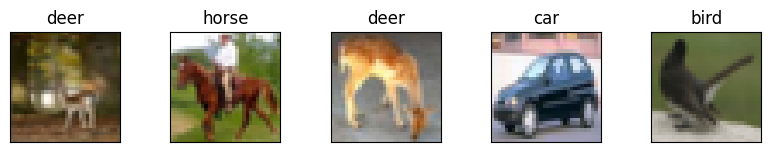

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

image_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

indices = torch.randperm(len(image_set))[:5]
images = [np.asarray(image_set[i][0]) for i in indices]
labels = [image_set[i][1] for i in indices]

# Visualize the images using matplotlib
fig = plt.figure(figsize=(10, 10))
for i in range(5):
    ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[])
    ax.imshow(images[i])
    ax.set_title(classes[labels[i]])